# GreenRivers MORO

## 1. Introduction

# RELINK these
In the previous two files, we performed open exploration of the base case (do nothing) with 1000 scenarios ([here](1.%20Open%20exploration%20base%20case.ipynb)) and a sample run with 400 scenarios and 75 policies ([here]()). The first step gave us an impression of what the system might look like if we do nothing. With the second, we were able to learn a lot more about the modelled world. Most importantly, we wanted to know what the total output space might look like, and if any policies (set of decisions) would lead to a worse outcome than the base case.

With this information, we can begin doing Multi-objective Robust Optimization (MORO) with the model to find a set of non-dominated (i.e. best) policies across a whole range of scenarios.

[WORDS](#s1)



### <a id="s1">1.1 Methodology</a>
A methodology summary follows below; more detailed discussion of each step lives near it. Our MORO approach is based on Kwakkel, J. H., Haasnoot, M., & Walker, W. E. (2015). Developing dynamic adaptive policy pathways: a computer-assisted approach for developing adaptive strategies for a deeply uncertain world. Climatic Change, 132(3), 373–386. https://doi.org/10.1007/s10584-014-1210-4.



1. Finally, run [MORO](#section_id). We use the $\epsilon$-NSGA-II algorithm here.

The term "robustness" is quite often defined differently. We use it as a measure of _how well a policy performs over different scenarios_.

As a brief overview of MORO, its steps are mainly:
1. Define a list of outcomes $o$ and what you want it to be optimized for (e.g. min)
1. Sample a set of $n$ scenarios
1. Create an $m$ sized population of test policies
1. Test each of those policies again the scenarios ($n \times m$ results)
1. Evaluate the performance of each policy for each outcome over those scenarios on aggregate to determine its *robustness* over scenarios ($o \times m$ results)
1. Take the best performing policies (e.g. best 10%), mutate them into $m$ policies, and test them again against the $n$ scenarios

## 2. Set up MORO

### 2.1 Load Required Packages and Modules

In [30]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle

from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter, Constraint)

from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario, SequentialEvaluator)

from ema_workbench.em_framework.evaluators import perform_experiments, optimize
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging, utilities

from visualization_functions import *

# Set a logging style so we can peer into the process
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

### 2.2 Define Robustness Functions

For each policy, EMAworkbench extracts $o$ outcomes in an $[1 \times o]$ array. However, to compare the policies against one another, we must define a robustness score for this entire set of outcomes.

Additionally, in the dike model, we get outcomes for multiple points in time and space (e.g. investment costs of Room for the River projects can be at any location and any of the decision times). This actually leaves us with an $[x \times o]$ array, where $x$ is the number of relevant variables for the overall outcome we are interested in. Therefore, we need to first sum that initial array into an $[1 \times o]$ array. This is done in the `sumover_robustness()` function below.

This step is quite important and potentially controversial: we are aggregating a metric in such a manner that individual performance is not necesarily reflected. We become impartial to location and time.

In [31]:
def sumover_robustness(*data):
    '''
    Aggregates multiple outcomes (across time and space) into one robustness score.
    
    Parameters
    ----------
    data : multiple n-length (but same) arrays and sums up element-wise into a [1,n] array

    Returns
    -------
    score: A score from the robustness function for the [1,n] array.
    '''
    score = robustness(sum(data))
    
    return score

Similary, the robustness score is arbitrary. Here, we define it in `robustness()` as the mean of the outcome across the scenarios multiplied by the interquartile range (IQR) of the same. We chose this approach because we want to minimize both the mean and the amount of variation in the outcome space. Little variation means the policy is quite robust, and a low mean lets us achieve a result closer to our objective (e.g. low required investment cost).

If someone wanted to maximize an outcome instead, then this function is not suitable. We add 0.5% of the mean to the IQR so that it does not dominate the robustness score. For instance, if the IQR is zero and the mean is not, the score will not be zero. If the mean is zero, the IQR will also already be zero (our model produces no negative values).

In [32]:
def robustness(data):
    '''
    Returns a robustness score for values in a [1,n] array, which you want to minimize.
    
    We want a function that returns 0 for the outcome to be in the range that we want and higher otherwise.
    
    This function multiplies the mean with the sum of the interquartile range and 0.5% of the mean.
    
    Parameters
    ----------
    data : a [1,n] array from sumover_robustness()

    Returns
    -------
    
    score : score for the [1,n] array
    
    '''
    
    # Normalize
    mean = np.mean(data)
    iqr = sp.stats.iqr(data) + mean * 0.005 # Add a small number so the mean is still considered in the score rather than 0
    score = mean * iqr
    
    return score

### 2.3 Determine MORO Convergence Metrics

In any optimization, it is important to look understand if the algorithm has converged or not. There's no easy way to explain this, but perhaps two of [Zeno's paradoxes](https://en.wikipedia.org/wiki/Zeno%27s_paradoxes#Dichotomy_paradox) provides the best illustration. These algorithms are iterative and move closer and closer to their 'best' or 'true' value. We want to know when it is close enough for our satisfaction.

![Zeno's Dichotomy Paradox by Martin Grandjean](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d7/Zeno_Dichotomy_Paradox.png/800px-Zeno_Dichotomy_Paradox.png)

Picture: Grandjean, Martin (2014) [Henri Bergson et les paradoxes de Zénon : Achille battu par la tortue ?](http://www.martingrandjean.ch/bergson-paradoxes-zenon-achille-tortue/). Accessed from [WikiMedia Commons](https://commons.wikimedia.org/wiki/File:Zeno_Dichotomy_Paradox.png).

The EMAworkbench comes with two metrics: a hypervolume indicator and $\epsilon$-convergence (epsilon). We will not go into further detail about them, but you can read about them [here (Reed et. al (2013)](https://doi.org/10.1016/j.advwatres.2012.01.005) and [here (Kasprzyk et. al (2012))](https://doi.org/10.1016/j.envsoft.2011.04.003), respectively (the former talks about $\epsilon$ as well and is a better introduction). There is also a fantastic video about hypervolume indicators [here](https://www.youtube.com/watch?v=cR4r1aNPBkQ).

#### 2.3.1 Hypervolume Indicator Convergence

The hypervolume indicator algorithm requires that we provide it with the expected range of each outcome. To understand the possibilities for these outcomes, we need to load our results from open exploration (random policies under random scenarios).

In [33]:
from ema_workbench.util.utilities import (save_results, load_results)

results = load_results('Outcomes/400Scenarios75Policies.csv')

[MainProcess/INFO] results loaded succesfully from /Users/jrwang/Documents/Coding/Model-based-decision-making/Outcomes/400Scenarios75Policies.csv


In [34]:
experiments, outcomes = results
outcomes = pd.DataFrame(outcomes)

We need to aggregate each outcome we are interested in by time and space (the problems of doing this are already discussed in 2.2). Then, we can find the robustness score for every policy under every outcome. Finally, we will want to extract the minimum and the maximum values for each outcome's robustness score.

In [35]:
aggregate_outcomes(outcomes,"Expected Annual Damage")
aggregate_outcomes(outcomes,"Dike Investment Costs")
aggregate_outcomes(outcomes,"Expected Number of Deaths")
aggregate_outcomes(outcomes,"RfR Total Costs")
aggregate_outcomes(outcomes,"Expected Evacuation Costs")

everything = pd.DataFrame(experiments["policy"]).join(outcomes)
robust_values = everything.groupby(by = ["policy"]).apply(robustness).iloc[:, -5:]

hyp_ranges_min = robust_values.apply(np.min)
hyp_ranges_max = robust_values.apply(np.max)

#### 2.3.2 $\epsilon$-convergence

Here, we follow Kasprzyk et al. in looking at the maximum variance of the dominating values (i.e. those near a Pareto front), which should yield $\epsilon$ values that will speed up the algorithm. For this, we can ran a small MORO instance. Kaspryzk et al. used Monte Carlo sampling across their open exploration results, which is much faster than our approach. However, we're not quite sure if they picked the ones near their Pareto front though. In that sense, our values should be more useful. Unfortunately, this means we will have to set up and run MORO briefly. For now, we will choose to use a very small grid size – `0.05` for all values.

In [36]:
# Initialize model parameters
from model.dike_model_function import DikeNetwork
from model.problem_formulation import get_model_for_problem_formulation

We again pick problem formulation `5` because it provides the most resolution of outcomes. Though we are aggregating them to apply the robustness score, we still want to see their raw output.

In [37]:
dike_model, planning_steps = get_model_for_problem_formulation(5)

Next we define, in EMAworkbench terms, all the parameters we want to optimize for and the constraints we want to add to the optimization algorithm.

Each of these $x$ variable names are aggregated in the $o$ outcomes. Explicitly, the outcome _investment costs in Room for the River projects_ can be made at all three decision steps (0, 1, and 2; $\therefore o = 3$). We store these in `var_list_rfr` and then define the outcome later as a `ScalarOutcome` with the name 'RfR Invest Score.'

The constraints are implented as 'soft constraints' to account for the environmental benefits of implementing Room for the River projects as early as possible. The Room for the River ecosystem (with wildlife, fauna, etc.) benefit more from the project the earlier it is implemented. Social benefits are not considered here, though we acknowledge that they exist (e.g. people value green space in and near cities).

In [38]:
# Store this method with a shorter name
MINIMIZE = ScalarOutcome.MINIMIZE

# List the names of vars to make `robustness_functions` a bit more read-able
var_list_damage = ['A.1_Expected Annual Damage 0','A.1_Expected Annual Damage 1','A.1_Expected Annual Damage 2',
                   'A.2_Expected Annual Damage 0','A.2_Expected Annual Damage 1','A.2_Expected Annual Damage 2',
                   'A.3_Expected Annual Damage 0','A.3_Expected Annual Damage 1','A.3_Expected Annual Damage 2',
                   'A.4_Expected Annual Damage 0','A.4_Expected Annual Damage 1','A.4_Expected Annual Damage 2',
                   'A.5_Expected Annual Damage 0','A.5_Expected Annual Damage 1','A.5_Expected Annual Damage 2']
var_list_deaths = ['A.1_Expected Number of Deaths 0','A.1_Expected Number of Deaths 1','A.1_Expected Number of Deaths 2',
                   'A.2_Expected Number of Deaths 0','A.2_Expected Number of Deaths 1','A.2_Expected Number of Deaths 2',
                   'A.3_Expected Number of Deaths 0','A.3_Expected Number of Deaths 1','A.3_Expected Number of Deaths 2',
                   'A.4_Expected Number of Deaths 0','A.4_Expected Number of Deaths 1','A.4_Expected Number of Deaths 2',
                   'A.5_Expected Number of Deaths 0','A.5_Expected Number of Deaths 1','A.5_Expected Number of Deaths 2']
var_list_dike = ['A.1_Dike Investment Costs 0','A.1_Dike Investment Costs 1','A.1_Dike Investment Costs 2',
                 'A.2_Dike Investment Costs 0','A.2_Dike Investment Costs 1','A.2_Dike Investment Costs 2',
                 'A.3_Dike Investment Costs 0','A.3_Dike Investment Costs 1','A.3_Dike Investment Costs 2',
                 'A.4_Dike Investment Costs 0','A.4_Dike Investment Costs 1','A.4_Dike Investment Costs 2',
                 'A.5_Dike Investment Costs 0','A.5_Dike Investment Costs 1','A.5_Dike Investment Costs 2']
var_list_rfr = ['RfR Total Costs 0', 'RfR Total Costs 1', 'RfR Total Costs 2']
var_list_evac = ['Expected Evacuation Costs 0', 'Expected Evacuation Costs 1', 'Expected Evacuation Costs 2']

# These functions need to only return one score value...
robustness_functions = [
    ScalarOutcome('Damage Score', variable_name = var_list_damage,
                  function = sumover_robustness, kind = MINIMIZE, expected_range=(0,4e16)),    
    ScalarOutcome('Deaths Score', variable_name = var_list_deaths,
                  function = sumover_robustness, kind = MINIMIZE, expected_range=(0,8.5e19)),
    ScalarOutcome('Dike Invest Score', variable_name = var_list_dike,
                  function = sumover_robustness, kind = MINIMIZE, expected_range=(1e18,1.3e7)),
    ScalarOutcome('RfR Invest Score', variable_name = var_list_rfr,
                  function = sumover_robustness, kind = MINIMIZE, expected_range=(2e16,9.1e17)),
    ScalarOutcome('Evac Score', variable_name = var_list_evac,
                  function = sumover_robustness, kind = MINIMIZE, expected_range=(0,2.5e12)),
]

constraints = [Constraint("discount_for_rfr_0", outcome_names="RfR Total Costs 0",
                          function=lambda x:max(0, x-426.24)),
               Constraint("discount_for_rfr_1", outcome_names="RfR Total Costs 1",
                          function=lambda x:max(0, x-284.16)),
               Constraint("discount_for_rfr_2", outcome_names="RfR Total Costs 2",
                          function=lambda x:max(0, x-142.08))]

Now, we can run MORO without the hypervolume indicator. We chose 10 scenarios and 200 nfes here so as to be a small set. **We can find the total number of possiblities – see #9**

In [39]:
# from ema_workbench.em_framework.optimization import EpsilonProgress
# from ema_workbench.em_framework.evaluators import BaseEvaluator

# BaseEvaluator.reporting_frequency = 0.1

# epsilons = [0.05,]*len(robustness_functions)

# # Record the run time
# start = time.time()

# # Run MORO
# with MultiprocessingEvaluator(dike_model) as evaluator:
#     results, convergence = evaluator.robust_optimize(robustness_functions,
#                                                      scenarios=10,
#                                                      nfe=200,
#                                                      epsilons=epsilons,
#                                                      convergence=[EpsilonProgress()],
#                                                      convergence_freq=1,
#                                                      constraint=constraints
#                                                     )

# end = time.time()
# print("Time taken: {:0.5f} minutes".format((end - start)/60))

# # Write the results so this step can be skipped when doing multiple analyzes
# with open('Outcomes/initial_Pareto_policies.pkl', 'wb') as file_pi:
#     pickle.dump(results, file_pi)

In [40]:
# Load the results
with open('Outcomes/initial_Pareto_policies.pkl', 'rb') as file_pi:
    results = pickle.load(file_pi)

Now that we can some policies somewhere on a Pareto front, we can run them under more scenarios (scenario discovery) and see the variance of their values across those scenarios. We use 50 scenarios just as a sample fo the scenario space.

In [41]:
# # Extract the levers for each Pareto policy
# policies = []
# for row in range(results.shape[0]):
#     policies.append(
#         # Do not include the damage scores
#         Policy(name=row, **results.iloc[row, :-5].to_dict())
#     )

# start = time.time()

# with MultiprocessingEvaluator(dike_model) as evaluator:
#     results = evaluator.perform_experiments(scenarios=50,policies=policies)
    
# end = time.time()
# print("Time taken: {:0.5f} minutes".format((end - start)/60))

# # Write the results so this step can be skipped when doing multiple analyzes
# with open('Outcomes/epsilon_results.pkl', 'wb') as file_pi:
#     pickle.dump(results, file_pi)

In [42]:
# Load the results
with open('Outcomes/epsilon_results.pkl', 'rb') as file_pi:
    results = pickle.load(file_pi)

With these outcomes, we can find the robustness scores again and then look for the maximum interquartile range to find our $o$ _noise-adjusted $\epsilon$ (epsilon) values_ (5 here).

In [43]:
experiments, outcomes = results

outcomes = pd.DataFrame(outcomes)
experiments = pd.DataFrame(experiments)
results = experiments.join(outcomes)
results = results.drop(columns="model")

# Aggregate across time and space
aggregate_outcomes(outcomes, "Expected Annual Damage")
aggregate_outcomes(outcomes, "Dike Investment Costs")
aggregate_outcomes(outcomes, "Expected Number of Deaths")
aggregate_outcomes(outcomes, "RfR Total Costs")
aggregate_outcomes(outcomes, "Expected Evacuation Costs")

everything = pd.DataFrame(experiments["policy"]).join(outcomes)

# Find the robustness scores
robust_values = everything.groupby(
    by=["policy"]).apply(robustness).iloc[:, -5:]

# Finally, find the IQR ranges that are our 'noise-adjusted epsilon values'
ranges = robust_values.apply(sp.stats.iqr)

In [44]:
ranges

Total Expected Annual Damage       3.287533e+15
Total Dike Investment Costs        3.660080e+18
Total Expected Number of Deaths    5.482093e+05
Total RfR Total Costs              1.096303e+17
Total Expected Evacuation Costs    4.118847e+10
dtype: float64

In [45]:
hyp_ranges_max

Total Expected Annual Damage       3.897572e+16
Total Dike Investment Costs        8.371133e+19
Total Expected Number of Deaths    1.127772e+07
Total RfR Total Costs              9.080500e+17
Total Expected Evacuation Costs    2.421692e+12
dtype: float64

In [46]:
hyp_ranges_min

Total Expected Annual Damage       0.000000e+00
Total Dike Investment Costs        1.096392e+18
Total Expected Number of Deaths    0.000000e+00
Total RfR Total Costs              2.113227e+16
Total Expected Evacuation Costs    0.000000e+00
dtype: float64

To save computation time, we are going to look at a subset of the output space. We already know from the first step **(LINK)** that the model is most senstitive to `A.1_pfail` and `A.3_pfail`. However, we also know that implementing any projects there will reduce the actual _risk_. Any dike heightening should strengthen the dikes there, which should lower the values, but the model does not currently account for such projects.

Regardless, we will find optimal solutions in these worst-case scenarios. We assume that if our policies can prepare us for the worst, then they will also perform in better conditions. Later, we will test and validate these assumptions. It is also important to note that we already found any policies will improve upon the base case's outcomes (the do-nothing case).

Therefore, we will limit our model's uncertainties to this worst-case space.

In [15]:
# From CART Analysis for deaths and damages

dike_model.uncertainties['A.1_pfail'] = RealParameter('A.1_pfail', 0, 0.367)
dike_model.uncertainties['A.3_pfail'] = RealParameter('A.3_pfail', 0, 0.226)

## 3. Run MORO

And now we can run the main computationally expensive MORO! Since we  are looking at our worst-case uncertainty space, we are confident in running the experiment for only 50 scenarios (compare to the **HOW MANY** possible).

In [47]:
from ema_workbench.em_framework import sample_uncertainties

n_scenarios = 50
scenarios = sample_uncertainties(dike_model, n_scenarios)
nfe = int(20000)

# Create a filename for saving (and loading if we need)
filename = 'Outcomes/MORO_s' + str(n_scenarios) + '_nfe' + str(nfe) + '.pkl'

In [17]:
from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress)
from ema_workbench.em_framework.evaluators import BaseEvaluator

BaseEvaluator.reporting_frequency = 0.1

epsilons = ranges.values
convergence = [HyperVolume(hyp_ranges_min, hyp_ranges_max),
               EpsilonProgress()]

# Time the run
start = time.time()

# Run MORO
with MultiprocessingEvaluator(dike_model) as evaluator:
    results, convergence = evaluator.robust_optimize(robustness_functions,
                                                     scenarios=scenarios,
                                                     nfe=nfe,
                                                     epsilons=epsilons,
                                                     convergence=convergence,
                                                     convergence_freq=20,
                                                     logging_freq=1,
                                                     constraint=constraints
                                                     )

end = time.time()
print("Time taken: {:0.5f} minutes".format((end - start)/60))

# Save the run results
with open(filename, 'wb') as file_pi:
    pickle.dump((results, convergence), file_pi)
    
# Record the runtime in a separate notebook for benchmarking
time_str = "Time: " + str((end - start)/60) + " minutes\t Scenarios: " + \
                str(n_scenarios) + "\t NFEs: " + str(nfe) + "\n"
with open('Outcomes/latest_time.tsv', 'a') as f:
    f.write(time_str)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/101 nfe
[MainProcess/INFO] generation 1: 100/101 nfe
[MainProcess/INFO] optimization completed, found 1 solutions
[MainProcess/INFO] terminating pool


Time taken: 1.45867 minutes


In [48]:
import pickle

results, convergence = pickle.load(open(filename, 'rb'))

## 4. Evaluate Convergence

If the optimization does not converge, then the results that we have found are not very useful. Let's check them below.

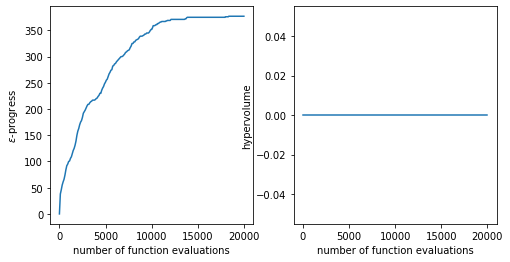

In [49]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

As seen above, our $\epsilon$ (epsilon) values do seem to converge around 12000 nfes. Unfortunately, the hypervolume indicator remains at 0. We hypothesize two factors that contribute to this:
1. The maximum value we set for the hypervolume may be so large that the hypervolume is so small relative to the total space that it is rounded to 0.00.
2. The maximum value is not large enough to capture the optimization outcome robustness scores.

Outside of these notebooks, we tested smaller sample runs with different expected ranges for the hypervolume. With `hyp_ranges_max` multiplied by between $10^{20}$ to $10^{23}$, we were able to see the value be defined between 0 and 1 (using some 'dirty hacks' to use the policies from the above run as the initial population for further optimization). Any higher values would yield 1 immediately. Thus, we cannot yet claim that the hypervolume indicator has shown convergence for our problem.

This is not to say we are not confident in our results. While two indicators could have been useful to understand our optimization, we expect that the hypervolume will require further debugging.

### 4.1 Checking for Hypervolume Convergence

To do this, we are going to run MORO again, but we want to initialize the optimizations with the policies we already found as initial policies (rather than starting from scratch again. This isn't supported yet by EMAworkbench, but we're submitted an issue to try and implement this in the future. The quickest way to achieve this is with a 'dirty hack' inside `platypus.algorithms.AbstractGeneticAlgorithm.initialize`.

```
def initialize(self):
        self.population = [self.generator.generate(self.problem) for _ in range(self.population_size)]
        self.evaluate_all(self.population)
```

We can comment out where `self.population` is initialized for the first time, and replace it with our own. However, we will need to create a list that is syntatically compatible with platypus.

### Create a list of solutions to feed back into platypus

In [20]:
# Slice for only the actual 31 levers (not the outputs)
pareto_policies = results.iloc[:,:-5]
pareto_solutions = []
# number of Pareto policies that we have
num_paretos = pareto_policies.shape[0]

# We need a little function to convert the levers into a format for platypus
def lever_to_platypus_variables(n,lever):
    variable = []
    
    # 15 is evac, 16 and higher are dike heights from 0-9 (four binary digits); all other are 0 or 1
    if n == 15:
        lever = '{0:03b}'.format(lever)
    elif n >= 16:
        lever = '{0:04b}'.format(lever)
    else:
        lever = '{0:01b}'.format(lever)
        
    for char in lever:
        variable.append(char == '1')
        
    return variable

from ema_workbench.em_framework.optimization import (to_robust_problem)
from platypus import (EpsNSGAII)

# Create policies properly in platypus grammar 
problem = to_robust_problem(dike_model, scenarios, robustness_functions, constraints=constraints,)
optimizer = EpsNSGAII(problem, epsilons, nfe=nfe,convergence=convergence)

# generate as many solutions as we have Pareto policies (this step is mostly for proper syntax)
init_policies = [optimizer.generator.generate(optimizer.problem) for n in range(num_paretos)]

for row_num in range(num_paretos):
    pareto_solultion = []
    
    for n, lever in enumerate(pareto_policies.iloc[row_num,:]):
        lever = lever_to_platypus_variables(n,lever)
        pareto_solultion.append(lever)
    
    # Write these good solutions into this list
    init_policies[row_num].variables = pareto_solultion
    
import dill as pickle
with open('Outcomes/Pareto_solutions.pkl', 'wb') as file_pi:
    pickle.dump(init_policies, file_pi)
# print(init_policies)

In [21]:
# with open('Outcomes/Pareto_solutions.pkl', 'rb') as file_pi:
#     init_policies = pickle.load(file_pi)

Now we can run MORO again with our adjusted `hyp_ranges_max` values.

In [22]:
from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress)
from ema_workbench.em_framework.evaluators import BaseEvaluator

BaseEvaluator.reporting_frequency = 0.1

epsilons = ranges.values
convergence = [HyperVolume(hyp_ranges_min, hyp_ranges_max*1.1e10),
               EpsilonProgress()]

n_scenarios = 1
scenarios = sample_uncertainties(dike_model, n_scenarios)
nfe = int(1)

# Time the run
start = time.time()

# Run MORO
with MultiprocessingEvaluator(dike_model) as evaluator:
    results, convergence = evaluator.robust_optimize(robustness_functions,
                                                     scenarios=scenarios,
                                                     nfe=nfe,
                                                     epsilons=epsilons,
                                                     convergence=convergence,
                                                     convergence_freq=20,
                                                     logging_freq=1,
                                                     constraint=constraints
                                                     )

end = time.time()
print("Time taken: {:0.5f} minutes".format((end - start)/60))

# Save the run results
with open('Outcomes/Hypervolume_check.pkl', 'wb') as file_pi:
    pickle.dump((results, convergence), file_pi)
    
# Record the runtime in a separate notebook for benchmarking
time_str = "Time: {:0.5f}".format((end - start)/60) + " minutes\t Scenarios: " + \
                str(n_scenarios) + "\t NFEs: " + str(nfe) + "\n"
with open('Outcomes/latest_time.tsv', 'a') as f:
    f.write(time_str)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/1 nfe
[MainProcess/INFO] optimization completed, found 1 solutions
[MainProcess/INFO] terminating pool


Time taken: 0.79088 minutes


In [23]:
results, convergence = pickle.load(open('Outcomes/Hypervolume_check.pkl', 'rb'))

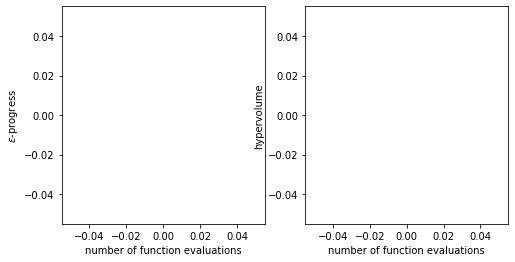

In [24]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

Let's see how these policies compare to the previous set on the Pareto front.

In [25]:
results

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Damage Score,Deaths Score,Dike Invest Score,RfR Invest Score,Evac Score
0,0,0,0,1,1,1,0,1,0,0,...,0,3,2,0,4,0.0,0.0,9.611307e+16,1.238108e+16,0.0


In [26]:
pareto_policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
0,1,0,0,1,1,0,0,1,0,0,...,3,1,7,0,9,6,2,3,2,6


In [27]:
# Discuss results

# Unfortunately, this doesn't work yet. The policies are not neatly fed to platypus (and then read back as Policy objects).